<font size="+3"><strong>Earthquake Damage In Gorkha🇳🇵 </strong></font>

<font size="+2"><strong>Part 4: Demographics</strong></font>

In [1]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

In [2]:
import sqlite3
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

GOALS
 - Prepare household dataset for binary classification.
 - Create a logistic regression model to predict severe damage.
 - Explain model predictions using odds ratio.
 - Interrogate important features based on caste.

Machine Learning Workflow 
 - Prepare Data
     - Import: household_demographics table
     - Explore: Group categorical feature
     - Split
     
 - Build Model
     - Baseline
     - Iterate
     - Evaluate
     
 - Communicate Results
     - Investigate apparent role of caste in building damage 

# Prepare Data

In [3]:
# Connect to the nepal.sqlite database
%reload_ext sql
%sql sqlite:////home/jovyan/nepal.sqlite

'Connected: @/home/jovyan/nepal.sqlite'

**Household_demographics Table** 

Select all columns from the `household_demographics` table, limiting my results to the first five rows.

In [4]:
%%sql
SELECT * 
FROM household_demographics
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
101,Male,31.0,Rai,Illiterate,Rs. 10 thousand,3.0,0.0
201,Female,62.0,Rai,Illiterate,Rs. 10 thousand,6.0,0.0
301,Male,51.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,13.0,0.0
401,Male,48.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,5.0,0.0
501,Male,70.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,8.0,0.0


How many observations are in the `household_demographics` table? 

In [5]:
%%sql
SELECT count(*)
FROM household_demographics

 * sqlite:////home/jovyan/nepal.sqlite
Done.


count(*)
249932


**Id_map Table**

Select all columns from the `id_map` table, limiting my results to the first five rows.

In [6]:
%%sql
SELECT *
FROM id_map
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


household_id,building_id,vdcmun_id,district_id
5601,56,7,1
6301,63,7,1
9701,97,7,1
9901,99,7,1
11501,115,7,1


I see that the `household_id` column is in common with `household_demographics` and I can use it to join them.

**Four-Table JOIN** 

In [7]:
%%sql
SELECT *
FROM household_demographics
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
101,Male,31.0,Rai,Illiterate,Rs. 10 thousand,3.0,0.0
201,Female,62.0,Rai,Illiterate,Rs. 10 thousand,6.0,0.0
301,Male,51.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,13.0,0.0
401,Male,48.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,5.0,0.0
501,Male,70.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,8.0,0.0


In [8]:
%%sql
SELECT h.*,
       i.vdcmun_id
FROM household_demographics AS h
JOIN id_map AS i ON i.household_id = h.household_id
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,vdcmun_id
5601,Female,69.0,Rai,Illiterate,Rs. 10-20 thousand,6.0,1.0,7
6301,Male,74.0,Rai,Non-formal education,Rs. 10-20 thousand,5.0,0.0,7
9701,Male,28.0,Rai,SLC or equivalent,Rs. 10-20 thousand,7.0,0.0,7
9901,Male,51.0,Gharti/Bhujel,Non-formal education,Rs. 10 thousand,6.0,0.0,7
11501,Male,29.0,Brahman-Hill,Class 8,Rs. 20-30 thousand,3.0,0.0,7


In [9]:
%%sql
SELECT h.*,
       i.vdcmun_id
FROM household_demographics AS h
JOIN id_map AS i ON i.household_id = h.household_id
JOIN building_structure AS s ON i.building_id = s.building_id
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,vdcmun_id
5601,Female,69.0,Rai,Illiterate,Rs. 10-20 thousand,6.0,1.0,7
6301,Male,74.0,Rai,Non-formal education,Rs. 10-20 thousand,5.0,0.0,7
9701,Male,28.0,Rai,SLC or equivalent,Rs. 10-20 thousand,7.0,0.0,7
9901,Male,51.0,Gharti/Bhujel,Non-formal education,Rs. 10 thousand,6.0,0.0,7
11501,Male,29.0,Brahman-Hill,Class 8,Rs. 20-30 thousand,3.0,0.0,7


So now I want to create a table with all the columns from `household_demographics`, all the columns from `building_structure`, the **`vdcmun_id`** column from `id_map`, and the **`damage_grade`** column from `building_damage`. My results should show only rows where the **`district_id`** is `4` and I will limit my results to the first five rows.

In [10]:
%%sql
SELECT h.*,
       s.*, 
       i.vdcmun_id,
       d.damage_grade
FROM household_demographics AS h
JOIN id_map AS i ON i.household_id = h.household_id
JOIN building_structure AS s ON i.building_id = s.building_id
JOIN building_damage AS d ON i.building_id = d.building_id
WHERE district_id = 4     
LIMIT 5                  

 * sqlite:////home/jovyan/nepal.sqlite
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,vdcmun_id,damage_grade
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,164002,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Repaired and used,"Stone, mud mortar",38,Grade 2
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,164081,2,2,21,200,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 2
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,164089,3,3,18,315,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 2
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,164098,2,2,45,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 3
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,164103,2,2,21,230,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 3


## Import

In [11]:
# Add the query I created in the previous task to the wrangle function below

def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
    SELECT h.*,
       s.*, 
       i.vdcmun_id,
       d.damage_grade
    FROM household_demographics AS h
    JOIN id_map AS i ON i.household_id = h.household_id
    JOIN building_structure AS s ON i.building_id = s.building_id
    JOIN building_damage AS d ON i.building_id = d.building_id
    WHERE district_id = 4

    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="household_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

**Wrangle Data** 

In [12]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0


## Explore

**High-Cardinality Features** 

In [13]:
# Combine the select_dtypes and nunique methods to see if there are any high- or low-cardinality categorical features in the dataset
df.select_dtypes("object").nunique()

gender_household_head              2
caste_household                   63
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

**Group Categorical Feature** 

In [14]:
top_10 = df["caste_household"].value_counts().head(10).index
top_10

Index(['Gurung', 'Brahman-Hill', 'Chhetree', 'Magar', 'Sarki', 'Newar', 'Kami',
       'Tamang', 'Kumal', 'Damai/Dholi'],
      dtype='object')

In [15]:
df["caste_household"].nunique()

63

In [16]:
df["caste_household"].value_counts().head(10)

Gurung          15119
Brahman-Hill    13043
Chhetree         8766
Magar            8180
Sarki            6052
Newar            5906
Kami             3565
Tamang           2396
Kumal            2271
Damai/Dholi      1977
Name: caste_household, dtype: int64

In [17]:
df["caste_household"].value_counts().tail(10)

Kewat            2
Thakali          2
Hajam/Thakur     2
Kayastha         1
Satar/Santhal    1
Byasi/Sauka      1
Kalar            1
Dhimal           1
Kalwar           1
Hyolmo           1
Name: caste_household, dtype: int64

In [18]:
df["caste_household"].value_counts().tail(15)

Thami            2
Teli             2
Kanu             2
Dhanuk           2
Rajbansi         2
Kewat            2
Thakali          2
Hajam/Thakur     2
Kayastha         1
Satar/Santhal    1
Byasi/Sauka      1
Kalar            1
Dhimal           1
Kalwar           1
Hyolmo           1
Name: caste_household, dtype: int64

In [19]:
df["caste_household"].value_counts().head(10).index

Index(['Gurung', 'Brahman-Hill', 'Chhetree', 'Magar', 'Sarki', 'Newar', 'Kami',
       'Tamang', 'Kumal', 'Damai/Dholi'],
      dtype='object')

In [20]:
top_10 = df["caste_household"].value_counts().head(10).index
top_10

Index(['Gurung', 'Brahman-Hill', 'Chhetree', 'Magar', 'Sarki', 'Newar', 'Kami',
       'Tamang', 'Kumal', 'Damai/Dholi'],
      dtype='object')

In [21]:
df["caste_household"].apply(lambda c: c if c in top_10 else "Other")

household_id
16400201    Chhetree
16408101    Chhetree
16408901       Magar
16409801    Chhetree
16410301    Chhetree
              ...   
23477401       Other
23480801       Other
23482101       Other
23482801       Other
23483501       Other
Name: caste_household, Length: 75883, dtype: object

In [22]:
df["caste_household"].apply(lambda c: c if c in top_10 else "Other").value_counts()

Gurung          15119
Brahman-Hill    13043
Chhetree         8766
Other            8608
Magar            8180
Sarki            6052
Newar            5906
Kami             3565
Tamang           2396
Kumal            2271
Damai/Dholi      1977
Name: caste_household, dtype: int64

In [23]:
# Add to my wrangle function so that the "caste_household" contains only the 10 largest caste groups

def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
    SELECT h.*,
       s.*, 
       i.vdcmun_id,
       d.damage_grade
    FROM household_demographics AS h
    JOIN id_map AS i ON i.household_id = h.household_id
    JOIN building_structure AS s ON i.building_id = s.building_id
    JOIN building_damage AS d ON i.building_id = d.building_id
    WHERE district_id = 4

    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="household_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Group caste column       
    top_10 = df["caste_household"].value_counts().head(10).index   

    df["caste_household"] = df["caste_household"].apply(         # For the rows that are not in those groups, "caste_household" should be changed to "Other"
        lambda c: c if c in top_10 else "Other"
    )
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [24]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0


In [25]:
df.select_dtypes("object").nunique()

gender_household_head              2
caste_household                   11
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

## Split

**Vertical Split** 

Now I can create my feature matrix `X` and target vector `y`. Since my model will only consider building and household data, `X` should not include the municipality column `"vdcmun_id"`. My target is `"severe_damage"`. 

In [26]:
target = "severe_damage"
X = df.drop(columns=[target, "vdcmun_id"])
y = df[target]

In [27]:
# Divide my data (X and y) into training and test sets using a randomized train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42             # My test set should be 20% of my total data & set a random_state for reproducibility
)

# Build Model

## Baseline

In [28]:
# Calculate the baseline accuracy score for my model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.63


## Iterate

In [29]:
# Create a Pipeline called model_lr 
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),  # Model has an OneHotEncoder transformer
    LogisticRegression(max_iter=3000)   # Model has a LogisticRegression predictor
)

# Fit model to training data
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender_household_head', 'caste_household',
                                     'education_level_household_head',
                                     'income_level_household',
                                     'land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=3000))])

## Evaluate

In [30]:
# Calculate the training and test accuracy scores for model_lr
acc_train = accuracy_score(y_train, model_lr.predict(X_train))
acc_test = accuracy_score(y_test, model_lr.predict(X_test))

print("LR Training Accuracy:", acc_train)
print("LR Validation Accuracy:", acc_test)

LR Training Accuracy: 0.7181497710275755
LR Validation Accuracy: 0.7220135731699282


# Communicate

**Odds Ratio DataFrame** 

First, I want to extract the feature names and importances from my model. Then create a pandas Series named `feat_imp`, where the index is `features` and the values are my the exponential of the `importances`.

In [31]:
features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

superstructure_Brick, cement mortar    0.320384
foundation_type_RC                     0.352191
roof_type_RCC/RB/RBC                   0.413963
ground_floor_type_RC                   0.535611
caste_household_Kumal                  0.540619
dtype: float64

**Odds Ratio Bar Chart I** 

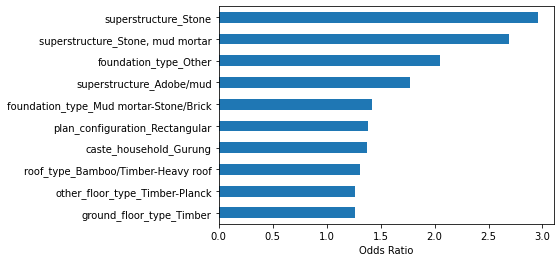

In [32]:
# Create a horizontal bar chart with the ten largest coefficients from feat_imp
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Odds Ratio");   # Label x-axis "Odds Ratio"

**Odds Ratio Bar Chart II** 

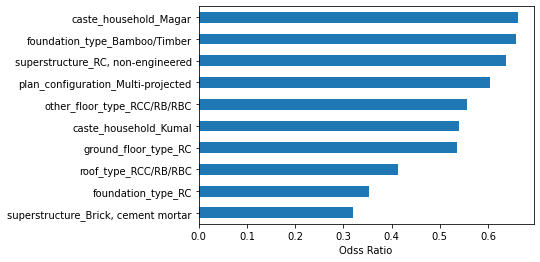

In [33]:
# Create a horizontal bar chart with the ten smallest coefficients from feat_imp
feat_imp.head(10).plot(kind="barh")
plt.xlabel("Odss Ratio");   # Label x-axis "Odds Ratio"

## Explore Some More

**Household Damage by Municipality**

Which municipalities saw the highest proportion of severely damaged buildings?

In [34]:
damage_by_vdcmun = (
    df.groupby("vdcmun_id")["severe_damage"].mean().sort_values(ascending=False)
)
damage_by_vdcmun

vdcmun_id
31    0.930199
32    0.851117
35    0.827145
30    0.824201
33    0.782464
34    0.666979
39    0.572344
40    0.512444
38    0.506425
36    0.503972
37    0.437789
Name: severe_damage, dtype: float64

In [35]:
# Create a DataFrame damage_by_vdcmun by grouping df by "vdcmun_id" and then calculating the mean of the "severe_damage" column
damage_by_vdcmun = (
    df.groupby("vdcmun_id")["severe_damage"].mean().sort_values(ascending=False)  # Sort damage_by_vdcmun from highest to lowest proportion
).to_frame()
damage_by_vdcmun

,severe_damage
vdcmun_id,
31,0.930199
32,0.851117
35,0.827145
30,0.824201
33,0.782464
34,0.666979
39,0.572344
40,0.512444
38,0.506425


**Municipality Damage Line Plot**

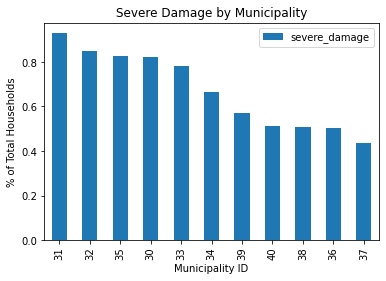

In [36]:
# Create a line plot of damage_by_vdcmun
damage_by_vdcmun.plot(kind="bar")
plt.xlabel("Municipality ID")               # Label x-axis "Municipality ID"
plt.ylabel("% of Total Households")         # Label y-axis "% of Total Households"
plt.title("Severe Damage by Municipality"); # Title "Household Damage by Municipality"

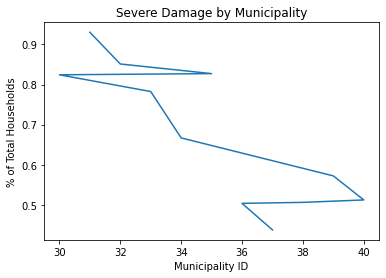

In [37]:
# Plot line
plt.plot(damage_by_vdcmun)
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

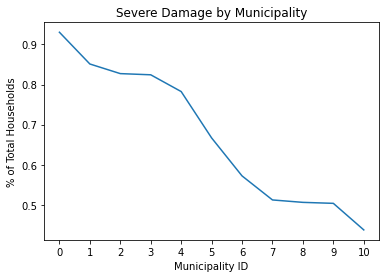

In [38]:
# Plot line
plt.plot(damage_by_vdcmun.values)
plt.xticks(range(11))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

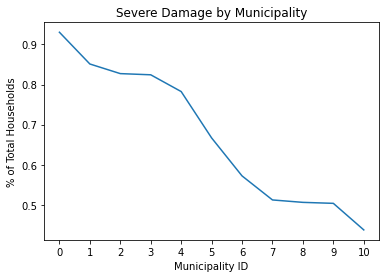

In [39]:
# Plot line
plt.plot(damage_by_vdcmun.values)
plt.xticks(range(len(damage_by_vdcmun)))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

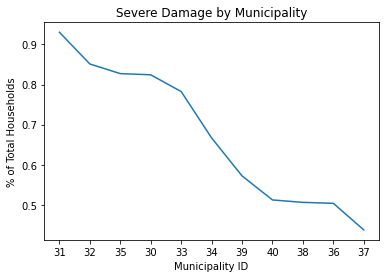

In [40]:
# Plot line
plt.plot(damage_by_vdcmun.values)
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

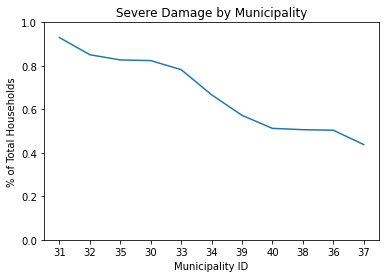

In [41]:
# Plot line
plt.plot(damage_by_vdcmun.values)
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

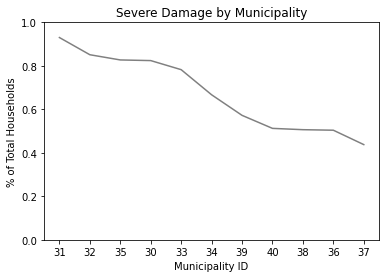

In [42]:
# Plot line
plt.plot(damage_by_vdcmun.values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

Given the plot above, my next question is: How are the Gurung and Kumal populations distributed across these municipalities?

**Municipality Damage Gurung Households** 

In [43]:
# Create a new column in damage_by_vdcmun that contains the the proportion of Gurung households in each municipality
df[df["caste_household"] == "Gurung"].head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
16525401,Male,53.0,Gurung,Illiterate,Rs. 10 thousand,6.0,0.0,20,425,18,Steep slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,"Stone, mud mortar",30,1
16526801,Female,40.0,Gurung,Illiterate,Rs. 10 thousand,5.0,0.0,20,800,16,Steep slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,"Stone, mud mortar",30,1
16542901,Male,78.0,Gurung,Non-formal education,Rs. 10 thousand,2.0,1.0,40,218,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Brick/Stone,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",30,1
16543701,Female,37.0,Gurung,Non-formal education,Rs. 20-30 thousand,5.0,0.0,12,216,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"Stone, mud mortar",30,1
16544201,Male,97.0,Gurung,Illiterate,Rs. 10 thousand,8.0,0.0,9,220,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",30,1


In [44]:
df[df["caste_household"] == "Gurung"].groupby("vdcmun_id")["severe_damage"].count()

vdcmun_id
30    2339
31    1363
32    2777
33      79
34     821
35    3229
36     829
37     676
38     557
39     734
40    1715
Name: severe_damage, dtype: int64

In [45]:
(
    df[df["caste_household"] == "Gurung"].groupby("vdcmun_id")["severe_damage"].count()
    / df.groupby("vdcmun_id")["severe_damage"].count()
    
)

vdcmun_id
30    0.338152
31    0.326937
32    0.387849
33    0.011943
34    0.385084
35    0.826889
36    0.143178
37    0.050485
38    0.049023
39    0.097971
40    0.246727
Name: severe_damage, dtype: float64

In [46]:
damage_by_vdcmun["Gurung"] = (
    df[df["caste_household"] == "Gurung"].groupby("vdcmun_id")["severe_damage"].count()
    / df.groupby("vdcmun_id")["severe_damage"].count()
    
)

In [47]:
damage_by_vdcmun

,severe_damage,Gurung
vdcmun_id,,
31,0.930199,0.326937
32,0.851117,0.387849
35,0.827145,0.826889
30,0.824201,0.338152
33,0.782464,0.011943
34,0.666979,0.385084
39,0.572344,0.097971
40,0.512444,0.246727
38,0.506425,0.049023


**Municipality Damage Kumal Households** 

In [48]:
(
    df[df["caste_household"] == "Kumal"].groupby("vdcmun_id")["severe_damage"].count()
    / df.groupby("vdcmun_id")["severe_damage"].count()
    
)

vdcmun_id
30         NaN
31         NaN
32         NaN
33    0.029478
34         NaN
35         NaN
36    0.003282
37    0.048842
38    0.100686
39    0.000267
40    0.036973
Name: severe_damage, dtype: float64

In [49]:
(
    df[df["caste_household"] == "Kumal"].groupby("vdcmun_id")["severe_damage"].count()
    / df.groupby("vdcmun_id")["severe_damage"].count()
    
).fillna(0)

vdcmun_id
30    0.000000
31    0.000000
32    0.000000
33    0.029478
34    0.000000
35    0.000000
36    0.003282
37    0.048842
38    0.100686
39    0.000267
40    0.036973
Name: severe_damage, dtype: float64

In [50]:
damage_by_vdcmun["Kumal"] = (
    df[df["caste_household"] == "Kumal"].groupby("vdcmun_id")["severe_damage"].count()
    / df.groupby("vdcmun_id")["severe_damage"].count()
    
).fillna(0)

In [51]:
damage_by_vdcmun

,severe_damage,Gurung,Kumal
vdcmun_id,,,
31,0.930199,0.326937,0.000000
32,0.851117,0.387849,0.000000
35,0.827145,0.826889,0.000000
30,0.824201,0.338152,0.000000
33,0.782464,0.011943,0.029478
34,0.666979,0.385084,0.000000
39,0.572344,0.097971,0.000267
40,0.512444,0.246727,0.036973
38,0.506425,0.049023,0.100686


**Destruction Visualizations** 

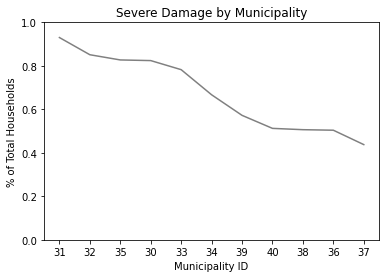

In [52]:
plt.plot(damage_by_vdcmun["severe_damage"].values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

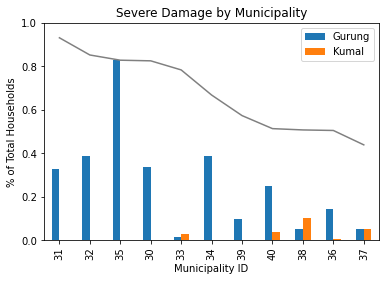

In [53]:
damage_by_vdcmun.drop(columns="severe_damage").plot(
    kind="bar"

)

plt.plot(damage_by_vdcmun["severe_damage"].values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")               
plt.ylabel("% of Total Households")         
plt.title("Severe Damage by Municipality");

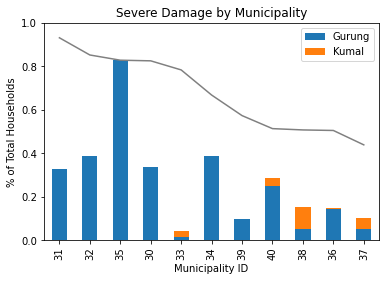

In [54]:
# Create a visualization that combines the line plot of severely damaged households I made above with a stacked bar chart showing the proportion of Gurung and Kumal households in each district
damage_by_vdcmun.drop(columns="severe_damage").plot(
    kind="bar", stacked=True 

)

plt.plot(damage_by_vdcmun["severe_damage"].values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")               # Label my x-axis "Municipality ID"
plt.ylabel("% of Total Households")         # Label my y-axis "% of Total Households"
plt.title("Severe Damage by Municipality");